This is a simple demo, explaining the basics of the astrodendro package (https://dendrograms.readthedocs.io/en/stable/index.html), for identifying clumps and clouds with with a simple dendogram algorithm in Python. I will go through importing the package, setting up the dendogram parameters, and exracting some of the information for analysis.

The first thing is to import the package:

In [1]:
from astrodendro import Dendrogram                            # This will import the dendogram tool

Then you need to load in the image data. I will load in a synthetic fractional Brownian motion image designed to replicate a column density image of a generic molecular cloud. This is achieved through loading in the fits package. See the fits tutorial for other uses of the astropy.io.fits module. I will also load the pyplot package for easy plotting of the images this tutorial will produce, and show what the synthetic image looks like. I will also import numpy so I can manipulate data arrays easily. 

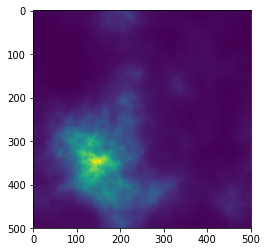

In [11]:
from astropy.io import fits                                   # Imports the fits module, which allows the opening of fits files
import matplotlib.pyplot as plt
import numpy as np

data = fits.getdata('/home/phoenixdata/c1649794/Python/NoiseFind/Fields/Cden/Cden_0001.fits') # Loads just the data as a numpy array
plt.figure()
plt.imshow(data)


Now we can apply the dendogram package to start finding clumps. Before we start, we need to look at our image and determine the noise level, or "sigma" of our image. It is an important quantity in ensuring our dendogram features are robust.

If your image is observational, you may have another image with the estimated noise, or be able to calculate the root mean square noise from the background. If the image is a fitted quantity, like column density or temperature, you may have another image of the uncertainty of the measurement at each pixel. Either is fine. As this is a synthetic image, I have identified the noise by taking the standard deviation in a dark region of the image. I define this below.

In [3]:
sigma = 1

With the noise calculated, lets actually create a dendrogram.

* The first argument will tell the module what data to work on. We want it to work on our "data" array. 
* The second argument will tell the module the minimum value to include in our dendrogram. Typically this is some multiple of the noise level, though you could set it to a background intensity level. The most important thing is to do it robustly. In this case, we will use 5 times the noise level, or `5*sigma`. This is a very robust value for most science results. `3*sigma` is also common.
* The third argument determines the difference in value between distinct layers, or branches, in the dendrogram. Without this, the dendrogram might try to put every individual pixel as a different branch or leaf, or decide the entire image is just a single structure!
* The fourth argument determines the minimum size for a branch or leaf. It's a fairly arbitrary number, but if you wanted to be robust, you could have some multiple of the resolution.

After we have created the dendrogram, we will print the "trunk" of the dendrogram. This will tell us what the lowest levels of our structure are.

In [4]:
dendro = Dendrogram.compute(data,                
                           min_value = 5*sigma,     
                           min_delta = 3*sigma,     
                           min_npix  = 10) 
dendro.trunk

[<Structure type=leaf idx=0>,
 <Structure type=branch idx=1>,
 <Structure type=leaf idx=3>,
 <Structure type=leaf idx=21>]

As you can see, there are 4 separate structures listed. 3 of them are leaf structures. That is, they contain only themselves. One of them is a branch, which itself will contain many more structures. More on that in a second. 

Lets go ahead and see what the contours of these structures look like. We will use a little bit of python trickery to take all 4 of these base structures, and create a mask of all of them, and then simply plot them as countours over our image. 

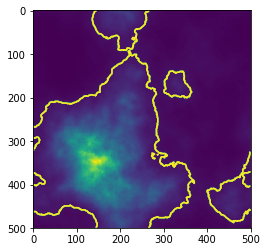

In [5]:
base = np.zeros(data.shape, dtype = bool)
for t in dendro.trunk:
    base = base | t.get_mask()

plt.figure()
plt.imshow(data)
plt.contour(base)

We can then examine the structure that is a branch (and contains more structures).

In [6]:
dendro.trunk[1].children

[<Structure type=leaf idx=2>, <Structure type=branch idx=4>]

As you can see, it contains 2 more structures, a leaf, and another branch. Plotting the contours as before gives the following image.

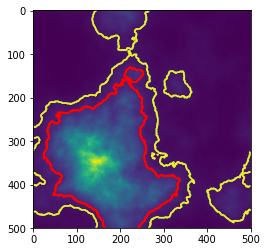

In [7]:
struc = np.zeros(data.shape, dtype = bool)
for c in dendro.trunk[1].children:
    struc = struc | c.get_mask()
    
plt.figure()
plt.imshow(data)
plt.contour(base)
plt.contour(struc, colors = 'red')

And we can go on. Lets examine the structures of the next level, and plot their contours. 

In [8]:
dendro.trunk[1].children[1].children

[<Structure type=leaf idx=5>, <Structure type=branch idx=6>]

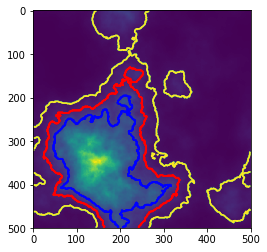

In [9]:
struc2 = np.zeros(data.shape, dtype = bool)
for c in dendro.trunk[1].children[1].children:
    struc2 = struc2 | c.get_mask()
    
plt.figure()
plt.imshow(data)
plt.contour(base)
plt.contour(struc, colors = 'red')
plt.contour(struc2, colors = 'blue')

And so on. So far, this is not useful for analysis, just for plotting pretty pictures. But each of the variables we have created for each level (`base`, `struc`, `struc2`) is a mask which can be applied to the base data image to extract the values. Lets get all the pixel values for `dendro.trunk[1].children[1].children[1]`, the larger of the 2 blue contours.

In [10]:
mask = dendro.trunk[1].children[1].children[1].indices()

data[mask]

array([20.93798218, 24.26917723, 21.444991  , ..., 30.32621144,
       27.55994271, 28.23869974])

Now we have all the values of data within that level, and can analyse them however we want.

There is a lot more you can do with astrodendro, but this is the basic information I wish I had had access to when I started to learn how to use it. For more information, visit https://dendrograms.readthedocs.io/en/stable/index.html